In [ ]:

import numpy as np
import os
import urllib.request
from astroquery.gaia import Gaia
from astropy import log
import pandas as pd
import os
import glob
import numpy as np
import importlib
import black_body_colors
from matplotlib import colors
import matplotlib.pyplot as plt

importlib.reload(black_body_colors)

data = pd.DataFrame()

i = 0
step = 50 
while i < 500:
    file_name = "data/gaia_{}_{}.csv".format(i, i+step)
    if os.path.isfile(file_name):
        log.info("Skipping: " + file_name)
    else:
        log.info("Downloading data for: " + file_name)
        job = Gaia.launch_job_async("select top 12000000"
            " bp_rp, phot_g_mean_mag+5*log10(parallax)-10 as mg" 
            " from gaiaedr3.gaia_source"
            " where parallax_over_error > 10"
            " and visibility_periods_used > 8"
            " and phot_g_mean_flux_over_error > 50"
            " and phot_bp_mean_flux_over_error > 20"
            " and phot_rp_mean_flux_over_error > 20"
            " and phot_bp_rp_excess_factor <"
            " 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)"
            " and phot_bp_rp_excess_factor >"
            " 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)"
            " and astrometric_chi2_al/(astrometric_n_good_obs_al-5)<"
            "1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))"
            + " and 1000/parallax <= {}".format(i + step)
            + " and 1000/parallax > {}".format(i),
            dump_to_file=True,
            #verbose=True,
            output_format="csv",
            output_file=file_name)
        r = job.get_results()
    i = i + step

# Grab the previously calculated results
data = pd.concat(pd.read_csv(f) for f in glob.glob("data/gaia_*.csv"))

# Convert to temperature
def index_to_temp(index):
    if index < -.25:
        index = -.25
    return 5601 / np.power(index + .3, 2.0/3.0)
temp = data.bp_rp.apply(index_to_temp)

# Convert to color from temperature via black body lookup
data['color'] = temp.apply(black_body_colors.get_color)



Stars: 33025569


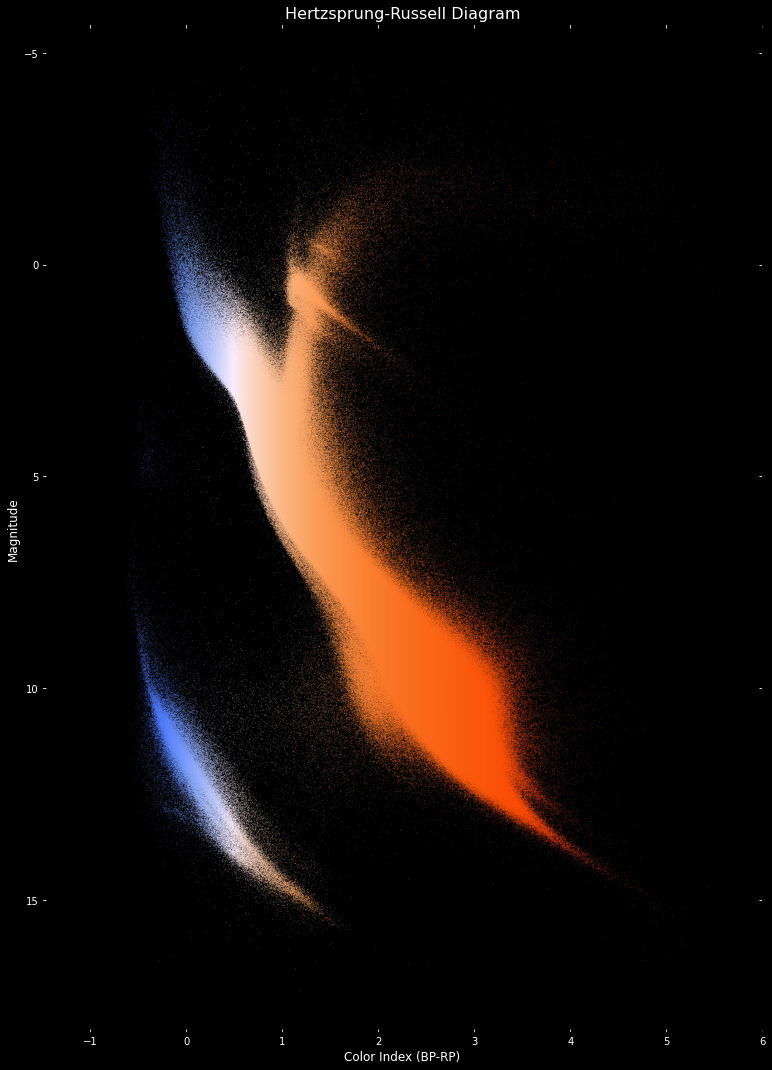

In [30]:
print("Stars: " + format(data.size))
# Image generation
# Color conversion
fig = plt.figure(
    figsize=(10, 14),
    facecolor='black'
    )
ax = fig.add_axes([1, 1, 1, 1])
ax.set_facecolor('black')
ax.set_title('Hertzsprung-Russell Diagram', color='white', fontsize=16)
ax.set_xlabel('Color Index (BP-RP)', color='white', fontsize=12)
ax.set_ylabel('Magnitude', color='white', fontsize=12)
ax.set_xlim(-1.5, 6.0)#max(data.bp_rp))
ax.set_ylim(min(data.mg) - 1.0, max(data.mg) + 1.0)
ax.tick_params(top='off', right='off', direction='in', colors='white')
ax.scatter( data.bp_rp, data.mg,
    marker='.',
    s=4.0,
    alpha=.25,
    zorder=0,
    facecolors=data['color'],
    color='darkslategray',
    linewidth=0)
ax.invert_yaxis()


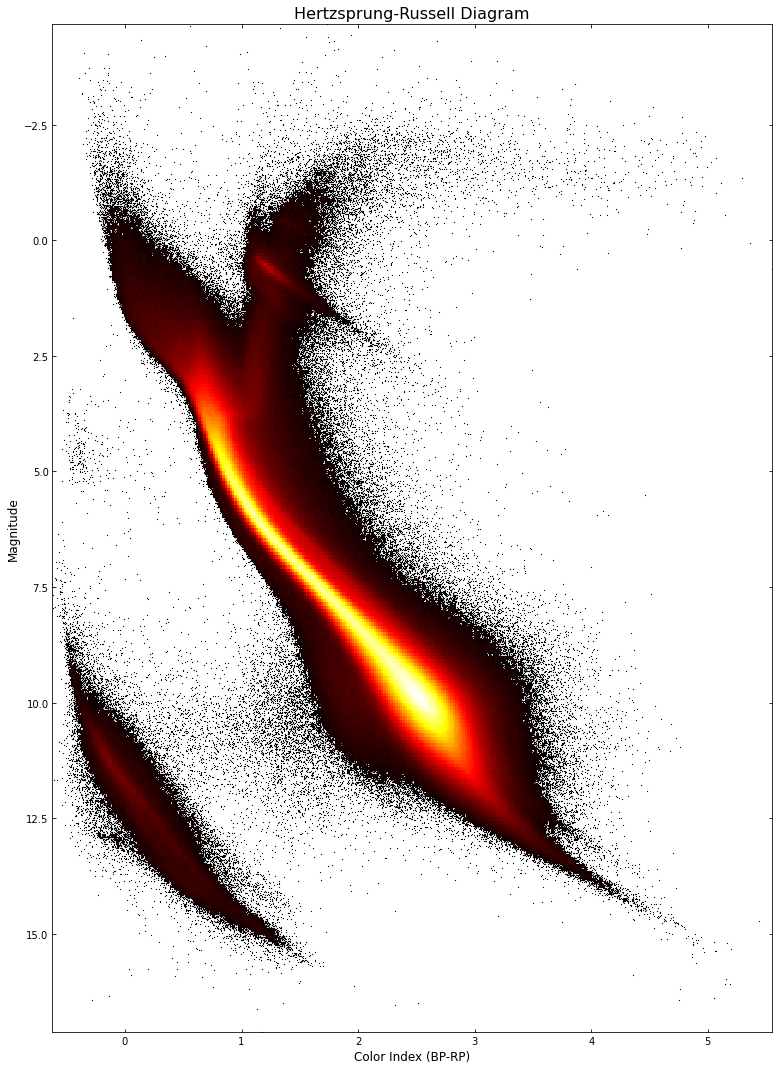

In [33]:

# Histogram
fig = plt.figure(
    figsize=(10, 14),
    facecolor='white'
    )
ax = fig.add_axes([1, 1, 1, 1])

ax.set_facecolor('white')
ax.set_title('Hertzsprung-Russell Diagram', color='black', fontsize=16)
ax.set_xlabel('Color Index (BP-RP)', color='black', fontsize=12)
ax.set_ylabel('Magnitude', color='black', fontsize=12)
ax.set_xlim(-1.5, 6.0)#max(data.bp_rp))
ax.set_ylim(min(data.mg) - 1.0, max(data.mg) + 1.0)
ax.tick_params(top='off', right='off', direction='in', colors='black')
h = ax.hist2d(data.bp_rp, data.mg, cmap='hot', bins=300, cmin=10, norm=colors.PowerNorm(0.5), zorder=0.5)
ax.scatter( data.bp_rp, data.mg,
    marker='.',
    s=6.0,
    alpha=1.0,
    zorder=0,
    color='black',
    linewidth=0)
ax.invert_yaxis()